## Librerías

In [1]:
# Libraries which will help us to manipulate a lil bit more our data
import numpy as np
import pandas as pd

# pandas: display all columns
pd.set_option('display.max_columns', None)

# Sklearn: Library for Train/Test Split // confusion matrix
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

# TensorFlow: Library for model training
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Matplotlib: Library for plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Functions: Library which contains all the functions that we'll use
import functions as fn

# Functions: Library which contains all the visualizations that we'll plot
import visualizations as vz

# Display plotly graphs in HTML
import plotly.io as pio
pio.renderers.default='notebook'

from collections import Counter

## Cargar datos

In [2]:
data= pd.read_parquet('Data_new_outliers.parquet')
data.drop(columns=["", "fraccion4", "Precio_raro", "articulo", "pais_origen_destino", "descripcion limpia", "descripcion", 
                   "TIGIE_D", "unidad_medida", "descripcion_unidad_medida", "codigo_pais", "continente"], inplace = True)

# Guardar en una variable el nombre de nuestra variable objetivo
target_variable ='outlier'

In [3]:
# Aplicar label encoder para castear texto a numérico
data = fn.label_encoder(data)

In [4]:
Counter(data["outlier"])

Counter({0: 887167, 1: 39122})

In [5]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

# Weights

In [6]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(data, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [7]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop(target_variable))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop(target_variable))
test_labels = np.array(test_df.pop(target_variable))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

$$w_j = \frac{n}{kn_j}$$

$\text{Where}$ \
$w_j: \ \text{is the weight to class j}$ \
$n: \ \text{is the number of observations}$ \
$n_j: \ \text{is the number of observations in class j, and}$ \
$k: \ \text{is the total number of classes.}$


In [9]:
unique_classes = [0, 1]

In [10]:
class_weight  = {}
for classes in unique_classes:
    class_weight[classes] = data.shape[0]/((data.loc[data[target_variable] == classes].shape[0])*len(unique_classes))

In [11]:
class_weight

{0: 0.5220488363521186, 1: 11.838466847298195}

In [12]:
EPOCHS = 10
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
weighted_model = make_model()

In [14]:
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/10
290/290 [==============================] - 2s 4ms/step - loss: 0.6614 - accuracy: 0.4516 - precision: 0.0560 - recall: 0.7576 - auc: 0.6650 - val_loss: 0.5878 - val_accuracy: 0.7273 - val_precision: 0.1066 - val_recall: 0.7360 - val_auc: 0.8150
Epoch 2/10
290/290 [==============================] - 1s 3ms/step - loss: 0.5513 - accuracy: 0.6715 - precision: 0.0885 - recall: 0.7310 - auc: 0.7869 - val_loss: 0.4957 - val_accuracy: 0.8267 - val_precision: 0.1625 - val_recall: 0.7427 - val_auc: 0.8759
Epoch 3/10
290/290 [==============================] - 1s 3ms/step - loss: 0.4892 - accuracy: 0.7697 - precision: 0.1263 - recall: 0.7547 - auc: 0.8471 - val_loss: 0.4469 - val_accuracy: 0.8617 - val_precision: 0.2009 - val_recall: 0.7597 - val_auc: 0.9023
Epoch 4/10
290/290 [==============================] - 1s 3ms/step - loss: 0.4563 - accuracy: 0.8101 - precision: 0.1526 - recall: 0.7704 - auc: 0.8748 - val_loss: 0.4231 - val_accuracy: 0.8691 - val_precision: 0.2136 - val_recall: 0

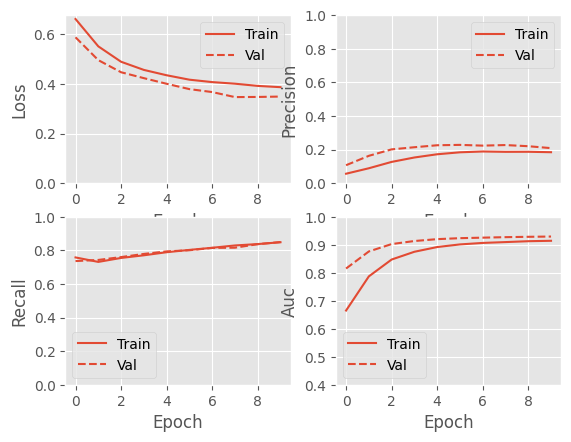

In [15]:
vz.plot_wmetrics(weighted_history)

In [16]:
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

91/91 [==============================] - 0s 1ms/step


In [17]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate No-Outliers Detected (True Negatives): ', cm[0][0])
    print('Legitimate No-Outliers Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Outliers Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Outliers Detected (True Positives): ', cm[1][1])
    print('Total Outliers: ', np.sum(cm[1]))
    print('Total No-Outliers: ', np.sum(cm[0]))

Legitimate No-Outliers Detected (True Negatives):  152075
Legitimate No-Outliers Incorrectly Detected (False Positives):  25313
Fraudulent Outliers Missed (False Negatives):  1168
Fraudulent Outliers Detected (True Positives):  6702
Total Outliers:  7870
Total No-Outliers:  177388


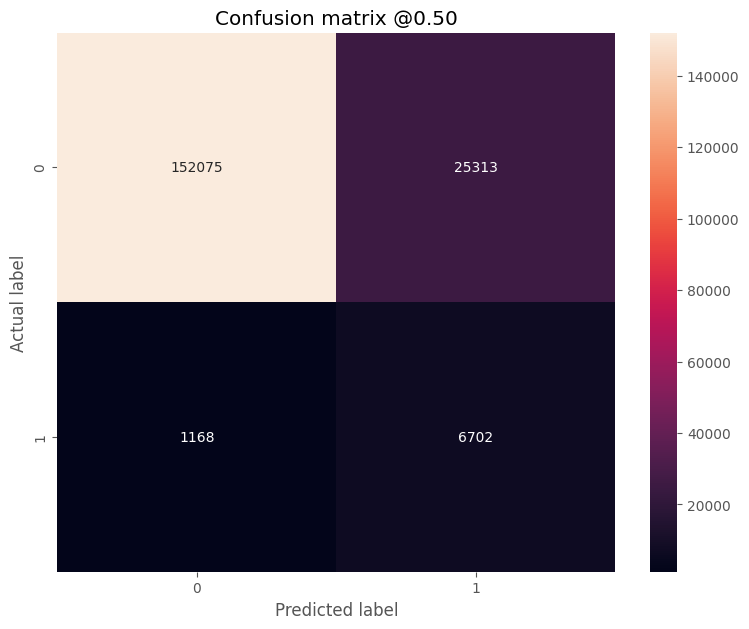

In [18]:
plot_cm(test_labels, test_predictions_weighted)

In [19]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', np.round(value, 2))

f1 = (2*weighted_results[2]*weighted_results[3])/(weighted_results[2]+weighted_results[3])
print("f1 : ", np.round(f1, 2))

loss :  0.35
accuracy :  0.86
precision :  0.21
recall :  0.85
auc :  0.93
f1 :  0.34


# Decile Analysis

In [20]:
decile_analysis = fn.decile_analysis(test_predictions_weighted, test_labels)
decile_analysis

,Batch,Cumulative Batch,Cumulative % Batch,True label,True label %,Cumulative label %,Probability Range
Decile,,,,,,,
1,18526,18526,0.1,5598,0.7113,0.7113,1.0 - 0.6666
2,18526,37052,0.2,1303,0.1656,0.8769,0.6666 - 0.4451
3,18526,55578,0.3,520,0.0661,0.9429,0.4451 - 0.3006
4,18526,74104,0.4,204,0.0259,0.9689,0.3006 - 0.2106
5,18526,92630,0.5,112,0.0142,0.9831,0.2106 - 0.1491
6,18526,111156,0.6,47,0.0060,0.9891,0.1491 - 0.1065
7,18526,129682,0.7,37,0.0047,0.9938,0.1065 - 0.0782
8,18526,148208,0.8,11,0.0014,0.9952,0.0782 - 0.0583
9,18525,166733,0.9,9,0.0011,0.9963,0.0583 - 0.0375


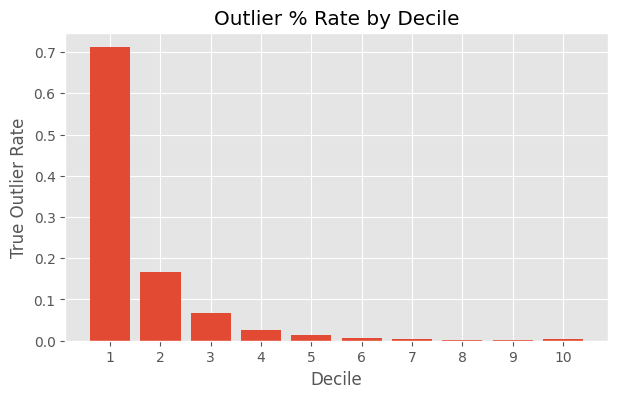

In [21]:
vz.decile_analysis_plot(decile_analysis["True label %"])